**In this notebook, I will implement SegNet based on VGG16 using PyTorch**

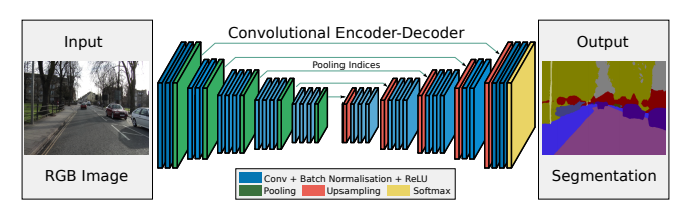

**Encoder**
- 2 ConvBatchnormRelu - MaxPool(2x2, stride 2)
- 2 ConvBatchnormRelu - MaxPool(2x2, stride 2)
- 3 ConvBatchnormRelu - MaxPool(2x2, stride 2)
- 3 ConvBatchnormRelu - MaxPool(2x2, stride 2)
- 3 ConvBatchnormRelu - MaxPool(2x2, stride 2)

**Decoder** (ConvTranspose2d for learning, Upsample or MaxUnpool for no-learning)
- Upsample - 3 ConvBatchnormRelu
- Upsample - 3 ConvBatchnormRelu
- Upsample - 3 ConvBatchnormRelu
- Upsample - 2 ConvBatchnormRelu
- Upsample - 2 ConvBatchnormRelu


In [ ]:
# import modules
import numpy as np;
import matplotlib.pyplot as plt;
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import models, transforms

!pip install albumentations==0.5.2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from PIL import Image
import cv2

import time
from tqdm import tqdm

from google.colab import drive

     |████████████████████████████████| 81kB 9.0MB/s 
     |████████████████████████████████| 952kB 31.9MB/s 
     |████████████████████████████████| 37.6MB 78kB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
# using GPU
if torch.cuda.is_available():
    device = torch.device("cuda");
else:
    device = torch.device("cpu");
print(device)

cuda


In [ ]:
# download pretrained vgg16_bn (with batch normalization)
vgg16 = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [ ]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
# define SegNet
class _EncoderBlock(nn.Module):
    def __init__(self,input_ch,output_ch,num_conv):
        super(_EncoderBlock, self).__init__()
        layers = [nn.Conv2d(input_ch,output_ch,kernel_size=3,stride=1, padding=1),
                  nn.BatchNorm2d(output_ch, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                  nn.ReLU(inplace=True)];
        if num_conv>1:
            layers += [nn.Conv2d(output_ch,output_ch,kernel_size=3,stride=1, padding=1),
                       nn.BatchNorm2d(output_ch, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                       nn.ReLU(inplace=True)]*(num_conv-1); 
        layers += [nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)];             
        self.encode = nn.Sequential(*layers);

    def forward(self,x):
        encoded, m_indices = self.encode(x);
        return encoded, m_indices

class _DecoderBlock(nn.Module):  
    def __init__(self,input_ch,output_ch,num_conv):
        super(_DecoderBlock, self).__init__()
        if num_conv>1:
            layers = [nn.Conv2d(input_ch,input_ch,kernel_size=3,stride=1, padding=1),
                      nn.BatchNorm2d(input_ch, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                      nn.ReLU(inplace=True)]*(num_conv-1); 
        layers += [nn.Conv2d(input_ch,output_ch,kernel_size=3,stride=1, padding=1),
                   nn.BatchNorm2d(output_ch, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                   nn.ReLU(inplace=True)];
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2);
        self.decode = nn.Sequential(*layers);

    def forward(self,x,m_indices):
        x = self.unpool(x, m_indices);
        decoded = self.decode(x);
        return decoded

class SegNet(nn.Module):
    def __init__(self, n_classes=21):
        super(SegNet,self).__init__()
        self.encoder1 = _EncoderBlock(3,64,2);
        self.encoder2 = _EncoderBlock(64,128,2);
        self.encoder3 = _EncoderBlock(128,256,3);
        self.encoder4 = _EncoderBlock(256,512,3);
        self.encoder5 = _EncoderBlock(512,512,3);

        self.decoder5 = _DecoderBlock(512,512,3);
        self.decoder4 = _DecoderBlock(512,256,3);
        self.decoder3 = _DecoderBlock(256,128,3);
        self.decoder2 = _DecoderBlock(128,64,2);
        self.decoder1 = _DecoderBlock(64,n_classes,2);

    def apply_vgg16_weights(self, vgg16):  
        self.encoder1.encode[0].weight.data = vgg16.features[0].weight.data;
        self.encoder1.encode[0].bias.data = vgg16.features[0].bias.data;        
        self.encoder1.encode[3].weight.data = vgg16.features[3].weight.data;
        self.encoder1.encode[3].bias.data = vgg16.features[3].bias.data;        
        self.encoder2.encode[0].weight.data = vgg16.features[7].weight.data;
        self.encoder2.encode[0].bias.data = vgg16.features[7].bias.data;        
        self.encoder2.encode[3].weight.data = vgg16.features[10].weight.data;
        self.encoder2.encode[3].bias.data = vgg16.features[10].bias.data;        
        self.encoder3.encode[0].weight.data = vgg16.features[14].weight.data;
        self.encoder3.encode[0].bias.data = vgg16.features[14].bias.data;        
        self.encoder3.encode[3].weight.data = vgg16.features[17].weight.data;
        self.encoder3.encode[3].bias.data = vgg16.features[17].bias.data;        
        self.encoder3.encode[6].weight.data = vgg16.features[20].weight.data;
        self.encoder3.encode[6].bias.data = vgg16.features[20].bias.data;        
        self.encoder4.encode[0].weight.data = vgg16.features[24].weight.data;
        self.encoder4.encode[0].bias.data = vgg16.features[24].bias.data;        
        self.encoder4.encode[3].weight.data = vgg16.features[27].weight.data;
        self.encoder4.encode[3].bias.data = vgg16.features[27].bias.data;        
        self.encoder4.encode[6].weight.data = vgg16.features[30].weight.data;
        self.encoder4.encode[6].bias.data = vgg16.features[30].bias.data;        
        self.encoder5.encode[0].weight.data = vgg16.features[34].weight.data;
        self.encoder5.encode[0].bias.data = vgg16.features[34].bias.data;        
        self.encoder5.encode[3].weight.data = vgg16.features[37].weight.data;
        self.encoder5.encode[3].bias.data = vgg16.features[37].bias.data;        
        self.encoder5.encode[6].weight.data = vgg16.features[40].weight.data;
        self.encoder5.encode[6].bias.data = vgg16.features[40].bias.data;        
        
    def forward(self,img):
        encoded, m_indices1 = self.encoder1(img);
        encoded, m_indices2 = self.encoder2(encoded);
        encoded, m_indices3 = self.encoder3(encoded);
        encoded, m_indices4 = self.encoder4(encoded);
        encoded, m_indices5 = self.encoder5(encoded);       

        decoded = self.decoder5(encoded,m_indices5);
        decoded = self.decoder4(decoded,m_indices4);
        decoded = self.decoder3(decoded,m_indices3);
        decoded = self.decoder2(decoded,m_indices2);
        decoded = self.decoder1(decoded,m_indices1);

        return decoded       


In [ ]:
SegNet()

SegNet(
  (encoder1): _EncoderBlock(
    (encode): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (encoder2): _EncoderBlock(
    (encode): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inpl

In [ ]:
# mount google drive for pascal voc 2007 dataset
drive.mount('/content/drive')

# data folder and file names
'''
train_file = '/content/drive/MyDrive/MachineLearning/CNN_implementation/SegNet/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/ImageSets/Segmentation/trainval.txt';
img_path = '/content/drive/MyDrive/MachineLearning/CNN_implementation/SegNet/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/';
mask_path = '/content/drive/MyDrive/MachineLearning/CNN_implementation/SegNet/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/SegmentationClass/';
'''
train_file = '/content/drive/MyDrive/MachineLearning/CNN_implementation/SegNet/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/ImageSets/Segmentation/trainval.txt';
img_path = '/content/drive/MyDrive/MachineLearning/CNN_implementation/SegNet/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/JPEGImages/';
mask_path = '/content/drive/MyDrive/MachineLearning/CNN_implementation/SegNet/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/SegmentationClass/';



test_file = '/content/drive/MyDrive/MachineLearning/CNN_implementation/SegNet/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/ImageSets/Segmentation/test.txt';
img_path2 = '/content/drive/MyDrive/MachineLearning/CNN_implementation/SegNet/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/';
mask_path2 = '/content/drive/MyDrive/MachineLearning/CNN_implementation/SegNet/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/SegmentationClass/';


train_images = open(train_file, "rt").read().split("\n")[:-1]
test_images = open(test_file, "rt").read().split("\n")[:-1]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define dataset
class PascalVOC(Dataset):
    def __init__(self, imgs, img_path, mask_path, transform=None):
        """
        imgs: image file names
        img_path: raw JPG file path
        mask_path: raw PNG file path
        transform: resize/augmentation
        """
        super().__init__();
        self.imgs = imgs;
        self.img_path = img_path;
        self.mask_path = mask_path;
        self.transform = transform;
        self.numClasses = 2;
        self.class_probability = self.__compute_class_probability();


    def __len__(self):
        return len(self.imgs);

    def __getitem__(self,idx):
        image = Image.open(self.img_path+self.imgs[idx]+'.jpg');
        image = np.array(image);
        mask = Image.open(self.mask_path+self.imgs[idx]+'.png');
        mask = np.array(mask);
        # set n/a class to zero
        mask[mask==255] = 0;
        #mask[mask>0] = 1;        

        if self.transform != None:
            transformed = self.transform(image=image,mask=mask);
            image = transformed['image'];
            mask = transformed['mask'];
            mask = mask.long();
        return image, mask;

    def __compute_class_probability(self):

        
        classes_prob = np.ones(21);
        for i in range(len(self.imgs)):
            mask = Image.open(self.mask_path+self.imgs[i]+'.png');
            mask = np.array(mask);
            # set n/a class to zero
            mask[mask==255] = 0;
            #mask[mask>0] = 1;

            # zero weights for label 0 (background)
            for c in range(0,21):
                classes_prob[c] = classes_prob[c] + len(np.where(mask==c)[0])

        # weight of the smallest class is the highest
        classes_prob = np.max(classes_prob)/classes_prob;
        classes_prob = classes_prob/np.max(classes_prob);
        classes_prob = torch.tensor(classes_prob).to(device)
        classes_prob = classes_prob.float()
        
        '''
        classes_prob = np.ones(21);
        classes_prob[0] = 0; # to dismiss background glass
        classes_prob = torch.tensor(classes_prob).to(device)
        classes_prob = classes_prob.float()
        '''
        return classes_prob


In [ ]:
# image transform for training
transform_train = A.Compose([                             
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Rotate(limit=20, border_mode=cv2.BORDER_CONSTANT,p=1),
    A.SmallestMaxSize(max_size=300),
    A.RandomScale(p=1),    
    A.ElasticTransform(p=0.8),
    A.RandomCrop(224,224),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()]);

# image transform for validation, test
transform_test = A.Compose([
    A.SmallestMaxSize(max_size=224),
    A.CenterCrop(224,224),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()]);


In [ ]:
# dataset & dataloader
train_ds = PascalVOC(train_images,img_path,mask_path,transform=transform_train);
test_ds = PascalVOC(test_images,img_path2,mask_path2,transform=transform_test);

train_loader = DataLoader(train_ds, batch_size=32, num_workers = 2, shuffle=True, drop_last=True);
test_loader = DataLoader(test_ds, batch_size=32, num_workers = 2, shuffle=True, drop_last=True);

In [ ]:
# weight of the lowest frequent class is the highest
train_ds.class_probability

tensor([0.0040, 0.4241, 1.0000, 0.3584, 0.5488, 0.4569, 0.1807, 0.2217, 0.1260,
        0.3158, 0.3125, 0.2515, 0.1675, 0.3190, 0.2869, 0.0629, 0.5409, 0.3752,
        0.2216, 0.1988, 0.3813], device='cuda:0')

In [ ]:
myModel = SegNet();
myModel.apply_vgg16_weights(vgg16)
myModel.to(device)

# unfreeze all parametrs
for param in myModel.parameters():
    param.requires_grad = True;

# freeze parameters until encoders
for param in myModel.encoder1.parameters():
    param.requires_grad = False;
for param in myModel.encoder2.parameters():
    param.requires_grad = False;
for param in myModel.encoder3.parameters():
    param.requires_grad = False;
for param in myModel.encoder4.parameters():
    param.requires_grad = False;
for param in myModel.encoder5.parameters():
    param.requires_grad = False;

# loss function
def loss_fun(y_pred, y_true):
    return nn.CrossEntropyLoss(weight=train_ds.class_probability)(y_pred, y_true);
    #return nn.CrossEntropyLoss()(y_pred, y_true);    


# Optimizer
learning_rate = 1e-4
#lambda1 = lambda epoch: 0.5 ** epoch
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, myModel.parameters()), lr=learning_rate);
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

In [ ]:
### load pre-trained weights ###
train_loss = [];
valid_loss = [];
model_path = '/content/drive/MyDrive/MachineLearning/CNN_implementation/SegNet/SegNet_vgg16.pt';

def load_checkpoint(filepath, myModel):
    checkpoint = torch.load(filepath);
    myModel.load_state_dict(checkpoint['state_dict']);
    train_loss = checkpoint['train_loss'];
    valid_loss = checkpoint['valid_loss'];
    learning_rate = checkpoint['learning_rate'];    
    return myModel, train_loss, valid_loss, learning_rate;

myModel, train_loss, valid_loss, learning_rate = load_checkpoint(model_path, myModel);
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, myModel.parameters()), lr=learning_rate);

100%|██████████| 91/91 [06:56<00:00,  4.57s/it, loss=0.08026345074176788]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


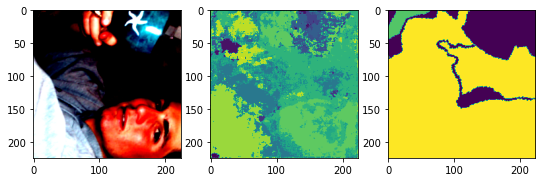

epoch#: 14, train_loss: 0.08154616513095059 , valid_loss: 0.08878933389981587
2.5e-06
stop# =  1


100%|██████████| 91/91 [07:00<00:00,  4.62s/it, loss=0.0750584602355957]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


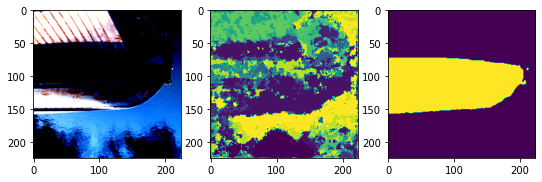

epoch#: 15, train_loss: 0.08115087760673774 , valid_loss: 0.08864296476046245
2.5e-06
stop# =  2


100%|██████████| 91/91 [07:07<00:00,  4.70s/it, loss=0.08740270137786865]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


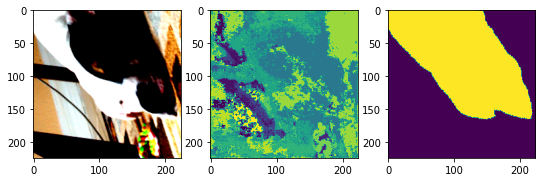

epoch#: 16, train_loss: 0.08125531542432177 , valid_loss: 0.08885504802068074
2.5e-06
stop# =  3


In [ ]:
learning_rate = 0.25*1e-5
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, myModel.parameters()), lr=learning_rate);

### train & validation
stopNum = 0;
for epoch in range(20):
    train_loss_epoch = 0;
    myModel.train();
    t_start = time.time();

    ### train
    pbar_train = tqdm(iter(train_loader), total=len(train_loader),position=0, leave=True);
    for step, (img,mask) in enumerate(pbar_train):
        img, mask = img.to(device), mask.to(device);
        y_pred = myModel(img);
        lossNow = loss_fun(y_pred,mask);
        
        # Zero gradients before a backward pass, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        lossNow.backward()        
        optimizer.step()        
        train_loss_epoch += lossNow.detach()/img.size(0);
        pbar_train.set_postfix({'loss': str(lossNow.cpu().detach().numpy()/img.size(0))})

    train_loss_epoch = train_loss_epoch.cpu().detach().numpy()/len(train_loader);
    train_loss.append(train_loss_epoch);    
    t_end = time.time();

    ### draw an example
    idx = 12
    aaa = np.argmax(y_pred.cpu().detach().numpy(),axis=1)
    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1)
    plt.imshow(img.cpu().detach().numpy()[idx,:,:,:].transpose(1,2,0))
    plt.subplot(1,3,2)
    plt.imshow(aaa[idx,:,:])
    plt.subplot(1,3,3)
    plt.imshow(mask.cpu().detach().numpy()[idx,:,:])
    plt.pause(1)    

    valid_loss_epoch = 0;
    myModel.eval();
    t_start = time.time();
    ### validation, test
    #pbar_test = tqdm(iter(test_loader), total=len(test_loader),position=0, leave=True);    
    for step, (img,mask) in enumerate(test_loader):
        img, mask = img.to(device), mask.to(device);
        y_pred = myModel(img);

        lossNow = loss_fun(y_pred,mask);

        valid_loss_epoch += lossNow.detach()/img.size(0)
        #pbar_test.set_postfix({'loss': str(lossNow.detach()/img.size(0))})

    valid_loss_epoch = valid_loss_epoch.cpu().detach().numpy()/len(test_loader);
    valid_loss.append(valid_loss_epoch);    
    t_end = time.time();
    
    print('epoch#: '+str(len(train_loss))+', train_loss: '+str(train_loss_epoch),
          ', valid_loss: '+str(valid_loss_epoch),flush=True)
    print(learning_rate)

    # save checkpoint
    if (epoch == 0) and (len(valid_loss)<5):
        minLoss = valid_loss_epoch;
        stopNum = 0;
    else:
        if len(valid_loss)<5:
            minLoss = np.mean(valid_loss);
        else:
            minLoss = np.mean(valid_loss[-5:]);
        if valid_loss_epoch<minLoss:
            minLoss = valid_loss_epoch;
            checkpoint = {'state_dict': myModel.state_dict(),
                          'learning_rate' : learning_rate,
                          'train_loss': train_loss,
                          'valid_loss': valid_loss}
            torch.save(checkpoint, model_path)    
            stopNum = 0;
        else:            
            stopNum += 1;
            print('stop# = ',str(stopNum),flush=True)
            if stopNum==3:
                break;
            '''    
            if (stopNum<3):
                learning_rate = learning_rate*0.5
                optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, myModel.parameters()), lr=learning_rate);
            else:
                break;            
            '''

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.5e-06


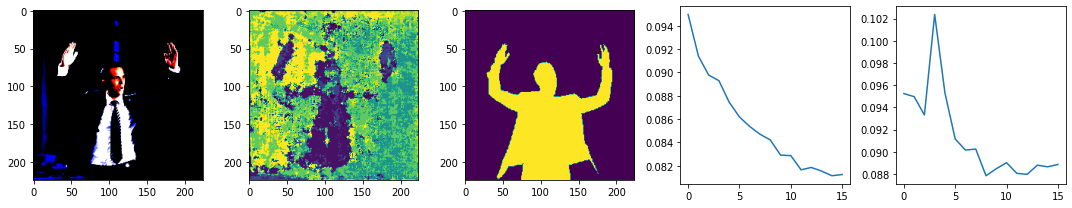

In [ ]:
print(learning_rate)
idx = 24
aaa = np.argmax(y_pred.cpu().detach().numpy(),axis=1)
plt.figure(figsize=(15,3))
plt.subplot(1,5,1)
plt.imshow(img.cpu().detach().numpy()[idx,:,:,:].transpose(1,2,0))
plt.subplot(1,5,2)
plt.imshow(aaa[idx,:,:])
plt.subplot(1,5,3)
plt.imshow(mask.cpu().detach().numpy()[idx,:,:])
plt.subplot(1,5,4)
box = np.ones(1)/1;
plt.plot(np.convolve(train_loss, box, mode='valid'))
plt.subplot(1,5,5)
plt.plot(np.convolve(valid_loss, box, mode='valid'))
plt.tight_layout()